In [1]:
import os
import time
import urllib

import cv2
import numpy as np
import torch
from IPython.display import clear_output, display
from PIL import Image

from sam2.build_sam import build_sam2_object_tracker

In [2]:
class Visualizer:
    def __init__(self,
                 video_width,
                 video_height,
                 ):
        
        self.video_width = video_width
        self.video_height = video_height

    def resize_mask(self, mask):
        mask = torch.tensor(mask, device='cpu')
        mask = torch.nn.functional.interpolate(mask,
                                               size=(self.video_height, self.video_width),
                                               mode="bilinear",
                                               align_corners=False,
                                               )
        
        return mask

    def add_frame(self, frame, mask):
        frame = frame.copy()
        frame = cv2.resize(frame, (self.video_width, self.video_height))
        
        mask = self.resize_mask(mask=mask)
        mask = (mask > 0.0).numpy()
        
        for i in range(mask.shape[0]):
            obj_mask = mask[i, 0, :, :]
            frame[obj_mask] = [255, 105, 180]
                
        rgb_frame = Image.fromarray(frame)
        clear_output(wait=True)
        display(rgb_frame)

In [3]:
# Download Example Video
VIDEO_STREAM = "./TUD-Stadtmitte-raw.webm"
url = 'https://motchallenge.net/sequenceVideos/TUD-Stadtmitte-raw.webm'

# Check if the file already exists
if not os.path.exists(VIDEO_STREAM):
    # If the file doesn't exist, download it
    urllib.request.urlretrieve(url, VIDEO_STREAM)
    print(f"Downloading {VIDEO_STREAM}...")
else:
    print(f"File {VIDEO_STREAM} already exists, skipping download.")

File ./TUD-Stadtmitte-raw.webm already exists, skipping download.


In [4]:
# Set SAM2 Configuration
NUM_OBJECTS = 2
YOLO_CHECKPOINT_FILEPATH = "yolov8x-seg.pt"
SAM_CHECKPOINT_FILEPATH = "../checkpoints/sam2.1_hiera_tiny.pt"
SAM_CONFIG_FILEPATH = "./configs/samurai/sam2.1_hiera_t.yaml"
OUTPUT_PATH = VIDEO_STREAM + "_segmented.mp4"
DEVICE = 'cuda:0'

In [5]:
#stream_url = "http://stage-ams-nfs.srv.axds.co/stream/adaptive/ucsc/walton_lighthouse/hls.m3u8"
stream_url = "./videos/bedroom.mp4"

In [6]:
# Open Video Stream
#video_stream = cv2.VideoCapture(VIDEO_STREAM)
video_stream = cv2.VideoCapture(stream_url)
video_height = int(video_stream.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_width = int(video_stream.get(cv2.CAP_PROP_FRAME_WIDTH))

# For real-time visualization
visualizer = Visualizer(video_width=video_width,
                        video_height=video_height
                        )

In [7]:
sam = build_sam2_object_tracker(num_objects=NUM_OBJECTS,
                                config_file=SAM_CONFIG_FILEPATH,
                                ckpt_path=SAM_CHECKPOINT_FILEPATH,
                                device=DEVICE,
                                verbose=False
                                )

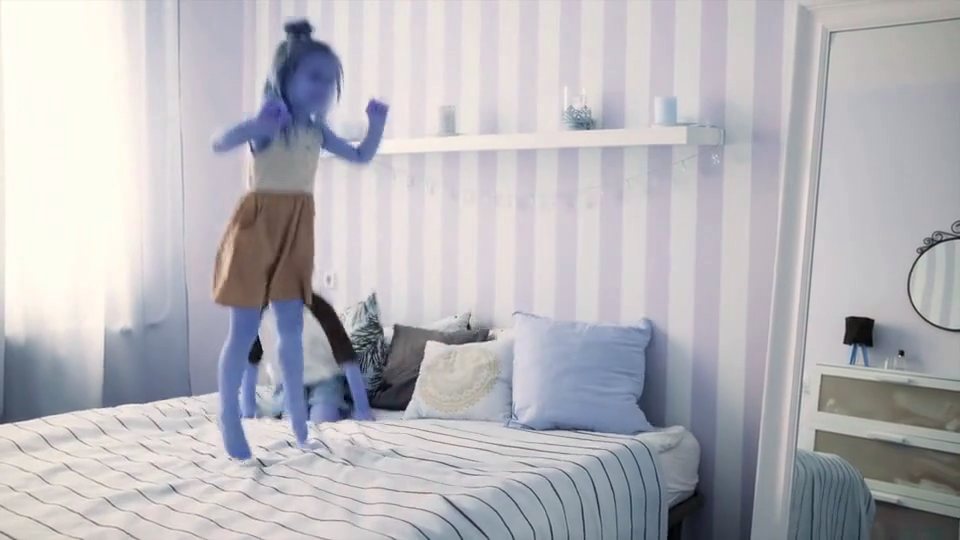

KeyboardInterrupt: 

In [8]:
available_slots = np.inf

first_frame = True
with torch.inference_mode(), torch.autocast('cuda:0', dtype=torch.bfloat16):
    while video_stream.isOpened():
        start_time = time.time()

        # Get next frame
        ret, frame = video_stream.read()
        # (1920, 2560)

        # Exit if no frames remaining
        if not ret:
            break

        # Convert frame from BGR to RGB
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Simulate detection on first frame
        if first_frame:
            # bbox = np.array([[[172, 92], [254, 325]], 
            #                  [[334, 76],  [439, 329]]]
            #                 )
            bbox = np.array([[[0, 580], [2560, 1920]] 
                             ]
                            )            
            
            sam_out = sam.track_new_object(img=img,
                                           box=bbox
                                           )
            # Draw the initial bounding boxes
            for box in bbox:
                top_left = tuple(box[0])
                bottom_right = tuple(box[1])
                cv2.rectangle(frame, top_left, bottom_right, (0, 255, 0), 2)
            
            first_frame = False
            
        else:
            sam_out = sam.track_all_objects(img=img)
            
        visualizer.add_frame(frame=frame, mask=sam_out['pred_masks'])
        
video_stream.release()